In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

### 5.1 Noisy Lennard-Jones-Gauss data

In [2]:
# Create some noisy data for the Lennard-Jones-Gauss potential and plot it.
def ljg(r, eps=0.5, sigma_squared=0.02, r0=1.7, eInf=0.0, A=1.0):
        return A*(r**-12 - 2*r**-6 - eps*torch.exp(-(r-r0)**2/(2*sigma_squared))) + eInf

def nice_plot(ax):
    ax.set(xlabel="$r$", ylabel="$V(r)$", xlim=[0.8, 2.0], ylim=[-1.2, 1.2])
    ax.axhline(0, color="black")
    ax.grid(alpha=0.5)

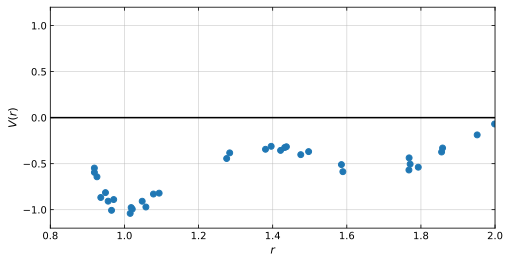

In [3]:
rmin = 0.8
rmax = 2.0
r1s = rmin + 0.25*np.random.rand(12)
r2s = rmax - 1 + np.random.rand(24)
rs_train = np.concatenate([r1s, r2s])
rs_train = torch.tensor(rs_train, dtype=torch.float32)
Vs_train = ljg(rs_train) + 0.05*torch.randn_like(rs_train)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(rs_train, Vs_train, 'o')
nice_plot(ax)

fig.savefig('ex51_fig1.png')

### 5.2 Deep neural network fit

In [4]:
# Fit with some deep neural networks. Investigate issues like:
#    Role of network size (and architecture). Vary amount and size of hidden layers.
#    Role of activation. Try something else but ReLU.
#    Reproducibility. Does it give the same every time?
#    Regularization. Do you see overfitting?

class NetworkModel(torch.nn.Module):
    def __init__(self, activation, N_hidden, layer_size):
        super().__init__()
        if activation.lower() == 'relu':
            self.activation = torch.relu
        elif activation.lower() == 'silu':
            self.activation = torch.nn.SiLU()
        self.input_layer = torch.nn.Linear(1, layer_size)
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(layer_size, layer_size) for _ in range(N_hidden)])
        self.output_layer = torch.nn.Linear(layer_size, 1)

    def forward(self, x):
        x = x.view(-1, 1)
        x = self.input_layer(x)
        for layer in self.hidden_layers:
            x = self.activation(x)
            x = layer(x)
        x = self.output_layer(x)
        return x.flatten()

def train(model, x_train, y_train, lr=0.001, steps=10000):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = torch.nn.MSELoss()

    for i in tqdm(range(steps), desc='Training'):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss_value = loss(y_pred, y_train)
        loss_value.backward()
        optimizer.step()

        # if i % max(1, steps//4) == 0 or i == steps-1:
        #     print(f'Step: {i}, Loss: {loss_value.item()}')
    
    return float(loss_value.item())

Training: 100%|██████████| 10000/10000 [00:09<00:00, 1043.35it/s]


ReLU activation, 2 hidden layers done.


Training: 100%|██████████| 10000/10000 [00:27<00:00, 361.12it/s]


ReLU activation, 4 hidden layers done.


Training: 100%|██████████| 10000/10000 [00:32<00:00, 308.41it/s]


ReLU activation, 6 hidden layers done.


Training: 100%|██████████| 10000/10000 [00:22<00:00, 447.42it/s]


SiLU activation, 2 hidden layers done.


Training: 100%|██████████| 10000/10000 [00:30<00:00, 323.71it/s]


SiLU activation, 4 hidden layers done.


Training: 100%|██████████| 10000/10000 [00:26<00:00, 376.63it/s]


SiLU activation, 6 hidden layers done.


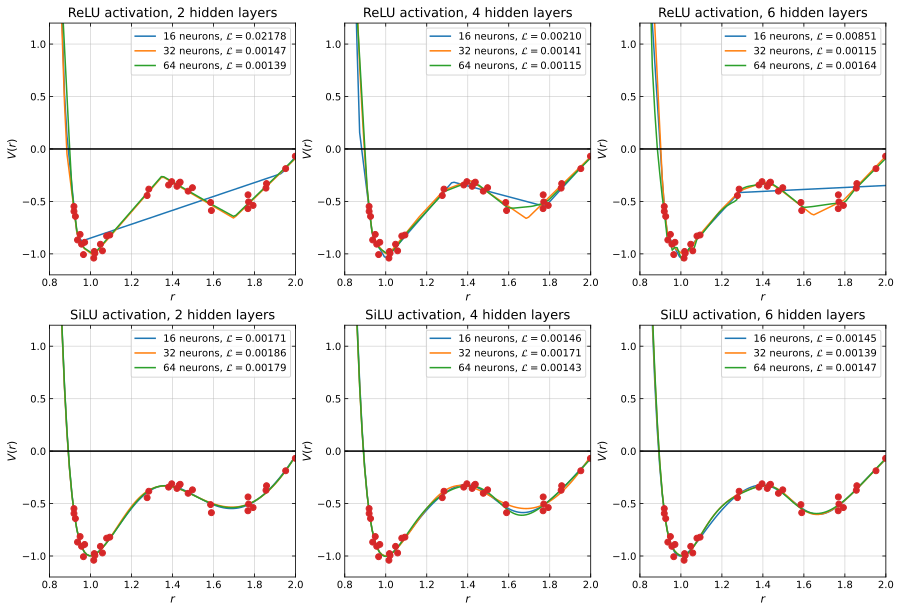

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
rs = torch.linspace(rmin, rmax, 100)
activations = ['ReLU', 'SiLU']
N_hiddens = [2, 4, 6]
layer_sizes = [16, 32, 64]

for row, activation in zip(axs, activations):
    for ax, N_hidden in zip(row, N_hiddens):
        for layer_size in layer_sizes:
            model = NetworkModel(activation, N_hidden, layer_size)
            loss_value = train(model, rs_train, Vs_train)
            with torch.no_grad():
                ax.plot(rs, model(rs), label=fr'{layer_size} neurons, $\mathcal{{L}}={loss_value:.5f}$')
        print(f'{activation} activation, {N_hidden} hidden layers done.')
        ax.plot(rs_train, Vs_train, 'o')
        ax.set_title(f'{activation} activation, {N_hidden} hidden layers')
        nice_plot(ax)
        ax.legend()

fig.savefig('ex51_fig2.png')

Let's try to include regularization and do it all again.

Training: 100%|██████████| 10000/10000 [00:13<00:00, 715.61it/s]


ReLU activation, 2 hidden layers done.


Training: 100%|██████████| 10000/10000 [00:18<00:00, 534.33it/s]


ReLU activation, 4 hidden layers done.


Training: 100%|██████████| 10000/10000 [00:23<00:00, 422.35it/s]


ReLU activation, 6 hidden layers done.


Training: 100%|██████████| 10000/10000 [00:13<00:00, 765.00it/s]


SiLU activation, 2 hidden layers done.


Training: 100%|██████████| 10000/10000 [00:15<00:00, 628.80it/s]


SiLU activation, 4 hidden layers done.


Training: 100%|██████████| 10000/10000 [00:19<00:00, 524.43it/s]


SiLU activation, 6 hidden layers done.


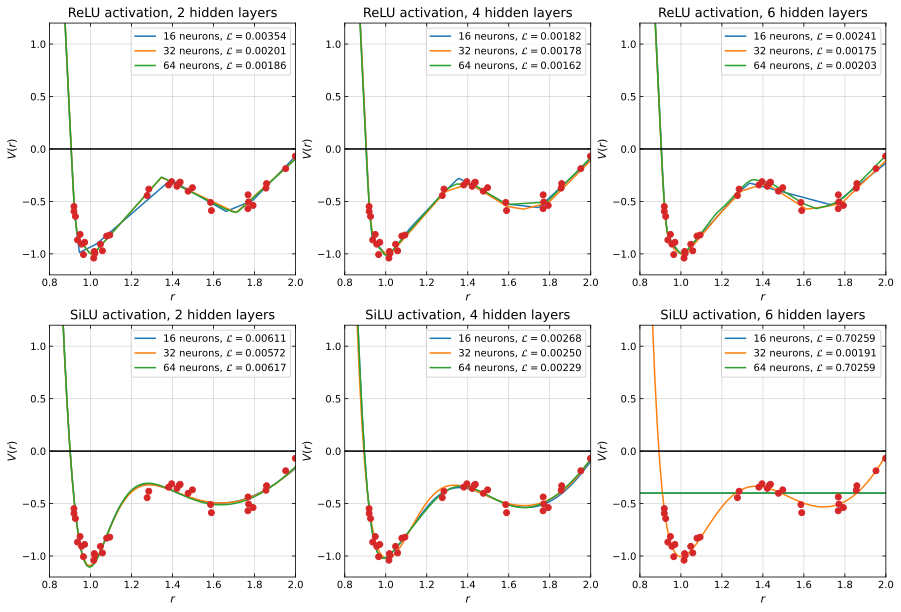

In [6]:
def train(model, x_train, y_train, lr=0.001, weight_decay=0.001, steps=10000):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss = torch.nn.MSELoss()

    for i in tqdm(range(steps), desc='Training'):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss_value = loss(y_pred, y_train)
        loss_value.backward()
        optimizer.step()

        # if i % max(1, steps//4) == 0 or i == steps-1:
        #     print(f'Step: {i}, Loss: {loss_value.item()}')
    
    return float(loss_value.item())



fig, axs = plt.subplots(2, 3, figsize=(15, 10))
rs = torch.linspace(rmin, rmax, 100)
activations = ['ReLU', 'SiLU']
N_hiddens = [2, 4, 6]
layer_sizes = [16, 32, 64]

for row, activation in zip(axs, activations):
    for ax, N_hidden in zip(row, N_hiddens):
        for layer_size in layer_sizes:
            model = NetworkModel(activation, N_hidden, layer_size)
            loss_value = train(model, rs_train, Vs_train)
            with torch.no_grad():
                ax.plot(rs, model(rs), label=fr'{layer_size} neurons, $\mathcal{{L}}={loss_value:.5f}$')
        print(f'{activation} activation, {N_hidden} hidden layers done.')
        ax.plot(rs_train, Vs_train, 'o')
        ax.set_title(f'{activation} activation, {N_hidden} hidden layers')
        nice_plot(ax)
        ax.legend()

fig.savefig('ex51_fig3.png')